In [6]:
!pip install pandas==2.0.3 numpy==1.25.2 scikit-learn==1.3.0 joblib==1.3.2


In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report

import joblib
import matplotlib.pyplot as plt
import seaborn as sns



In [8]:
# data preparation
def prepare_data(data):
    # Convert adaptivity level to numeric
    adaptivity_map = {'Low': 0, 'Moderate': 1, 'High': 2}
    data['Adaptivity Level'] = data['Adaptivity Level'].map(adaptivity_map)

    # Encode categorical variables
    le = LabelEncoder()
    categorical_cols = ['Gender', 'Education Level', 'Institution Type', 'IT Student',
                       'Location', 'Load-shedding', 'Financial Condition', 'Internet Type',
                       'Network Type', 'Class Duration', 'Self Lms', 'Device']

    for col in categorical_cols:
        data[col] = le.fit_transform(data[col])

    # Convert age ranges to numeric (using mid-point of range)
    age_map = {'1-5': 3, '6-10': 8, '11-15': 13, '16-20': 18, '21-25': 23, '26-30': 28}
    data['Age'] = data['Age'].map(age_map)

    return data

In [9]:
path = "/content/student-adaptability-dataset.csv"
df = pd.read_csv(path)



In [ ]:
df.head()

,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,Boy,21-25,University,Non Government,No,Yes,Low,Mid,Wifi,4G,3-6,No,Tab,Moderate
1,Girl,21-25,University,Non Government,No,Yes,High,Mid,Mobile Data,4G,1-3,Yes,Mobile,Moderate
2,Girl,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Moderate
3,Girl,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile,Moderate
4,Girl,16-20,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,0,No,Mobile,Low


In [10]:
data = prepare_data(df)

In [11]:
# Split features and target
X = data.drop('Adaptivity Level', axis=1)
y = data['Adaptivity Level']

In [23]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
def train_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} Results:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}\n")
    return model, mse, r2

In [17]:
# Linear Regression
lr_model, lr_mse, lr_r2 = train_evaluate_model(
    LinearRegression(),
    X_train_scaled, X_test_scaled, y_train, y_test,
    "Linear Regression"
)


Linear Regression Results:
Mean Squared Error: 0.3165
R2 Score: 0.2331



In [18]:
# Decision Tree
dt_model, dt_mse, dt_r2 = train_evaluate_model(
    DecisionTreeRegressor(random_state=42),
    X_train_scaled, X_test_scaled, y_train, y_test,
    "Decision Tree"
)

Decision Tree Results:
Mean Squared Error: 0.1035
R2 Score: 0.7492



In [25]:
# Random Forest
rf_model, rf_mse, rf_r2 = train_evaluate_model(
    RandomForestRegressor(random_state=42, n_estimators=100),
    X_train_scaled, X_test_scaled, y_train, y_test,
    "Random Forest"
)

Random Forest Results:
Mean Squared Error: 0.0992
R2 Score: 0.7595



In [32]:
# Find best model
models = {
    'Linear Regression': (lr_model, lr_mse, lr_r2),
    'Decision Tree': (dt_model, dt_mse, dt_r2),
    'Random Forest': (rf_model, rf_mse, rf_r2)
}

best_model_name = min(models.items(), key=lambda x: x[1][1])[0]
best_model = models[best_model_name][0]

print(f"Best performing model: {best_model_name}")

Best performing model: Random Forest


In [22]:
# Save best model and scaler
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [27]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print(feature_importance)

                feature  importance
10       Class Duration    0.219932
7   Financial Condition    0.149034
1                   Age    0.117000
0                Gender    0.070373
3      Institution Type    0.058928
9          Network Type    0.053254
5              Location    0.052869
2       Education Level    0.050856
8         Internet Type    0.049685
11             Self Lms    0.049251
6         Load-shedding    0.043722
12               Device    0.043222
4            IT Student    0.041873


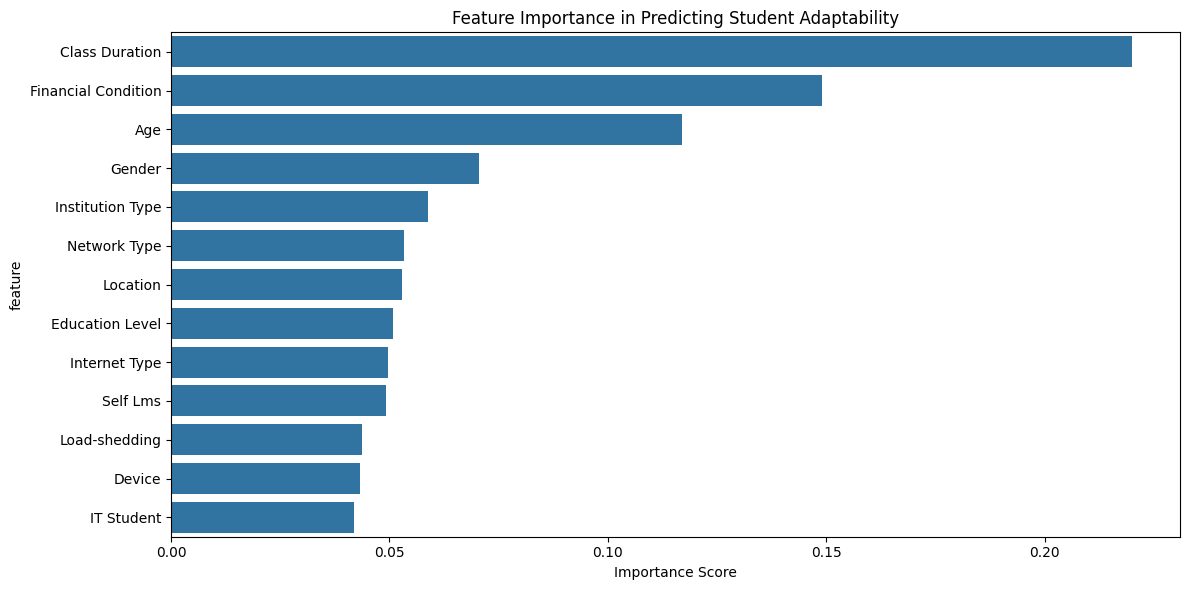


Top 5 Most Important Features:
            feature  importance
     Class Duration    0.219932
Financial Condition    0.149034
                Age    0.117000
             Gender    0.070373
   Institution Type    0.058928


In [29]:
# Create visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance in Predicting Student Adaptability')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Print top 5 most important features
print("\nTop 5 Most Important Features:")
print(feature_importance.head().to_string(index=False))

Model Accuracy


In [40]:
# Convert continuous predictions to discrete classes
def get_predicted_class(y_pred):
    return np.where(y_pred < 0.5, 0, np.where(y_pred < 1.5, 1, 2))

In [41]:
# Load model and make predictions
y_pred = best_model.predict(X_test_scaled)
y_pred_classes = get_predicted_class(y_pred)


In [42]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Model Accuracy: {accuracy:.2%}")

Model Accuracy: 91.29%


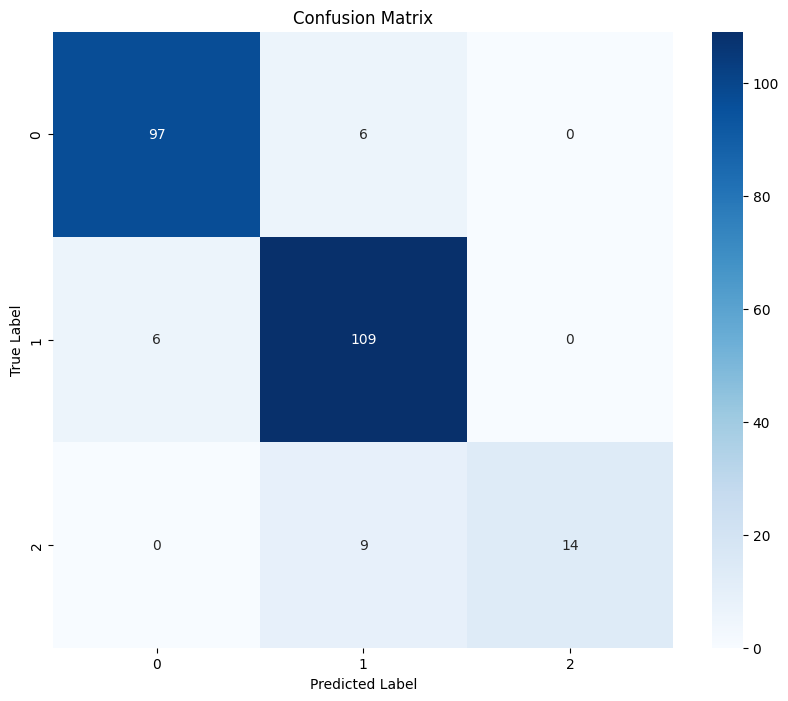

In [43]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [44]:
# Print detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_classes,
                          target_names=['Low', 'Moderate', 'High']))



Detailed Classification Report:
              precision    recall  f1-score   support

         Low       0.94      0.94      0.94       103
    Moderate       0.88      0.95      0.91       115
        High       1.00      0.61      0.76        23

    accuracy                           0.91       241
   macro avg       0.94      0.83      0.87       241
weighted avg       0.92      0.91      0.91       241



In [45]:
# Calculate accuracy per class
class_accuracy = {}
for i in range(3):
    mask = y_test == i
    class_acc = accuracy_score(y_test[mask], y_pred_classes[mask])
    class_accuracy[['Low', 'Moderate', 'High'][i]] = class_acc

print("\nAccuracy by Class:")
for class_name, acc in class_accuracy.items():
    print(f"{class_name}: {acc:.2%}")


Accuracy by Class:
Low: 94.17%
Moderate: 94.78%
High: 60.87%
